In [1]:
#imports
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import time
import pandas as pd
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import seaborn as sns
from sklearn.decomposition import PCA
from make_models import get_MRI_CVAE_3D
from tqdm import tqdm
import tensorflow as tf
from rsa_funcs import fit_rsa,make_RDM,get_triu

/data/bergerar/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
pwd

'/mmfs1/data/bergerar/BC-MRI-ADHD/Code'

In [3]:
#load data
stuff = np.load('../Assets/brain_array-440.npz')
print(list(stuff.keys()))

data = stuff['data']
control = stuff['controls']
patients = stuff['patients']
n = data.shape[0]
#print(data.shape)
#data[patients,:,:,:].shape
#data[patients].shape

data_patients = data[patients,:,:,:]
data_controls = data[control,:,:,:]

print(data_patients.shape)
print(data_controls.shape)

['data', 'controls', 'patients']
(179, 64, 64, 64)
(261, 64, 64, 64)


In [4]:
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(input_shape=(64,64,64,1),
                    latent_dim=2,
                    beta=1,
                    disentangle=False,
                    gamma=1,
                    bias=True,
                    batch_size = 64,
                    kernel_size = 3,
                    filters = 32,
                    intermediate_dim = 128,
                    opt=None)

In [5]:
cvae.load_weights('../Assets/tf_weights_10000_AB/tf_weightsAB')

In [6]:
data_patients.shape

(179, 64, 64, 64)

In [7]:
def get_reconstruction(data_in,adhd = True):

    z = z_encoder.predict(data_in)[0] # mu,std,sample
    s = s_encoder.predict(data_in)[0]

    if adhd==True:
        l = np.hstack((z,s))
    else:
        l = np.hstack((z,np.zeros(s.shape)))

    recon = cvae_decoder(l)[:,:,:,:,0]
    return recon

In [8]:
%%time
recon_patients = get_reconstruction(data_patients,adhd = True)
recon_controls = get_reconstruction(data_controls,adhd = False)


CPU times: user 1min 47s, sys: 26.1 s, total: 2min 14s
Wall time: 33 s


In [13]:
recon_patients.shape

TensorShape([179, 64, 64, 64])

In [10]:
np.array(recon_patients).max()

0.8697046

In [11]:
np.array(recon_patients).min()

0.008435845

In [12]:
np.array(data_patients).max()


1.0

In [13]:
np.array(data_patients).min()


0.0

In [26]:
# reconstructions = cvae_decoder.predict(np.hstack((background_features_adhd, salient_features_adhd)))

In [27]:
# reconstructions = reconstructions[:,:,:,:,0]

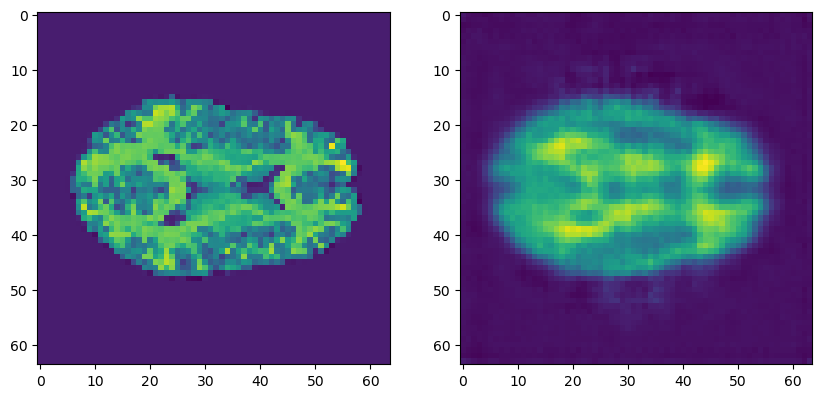

In [14]:
s = 0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

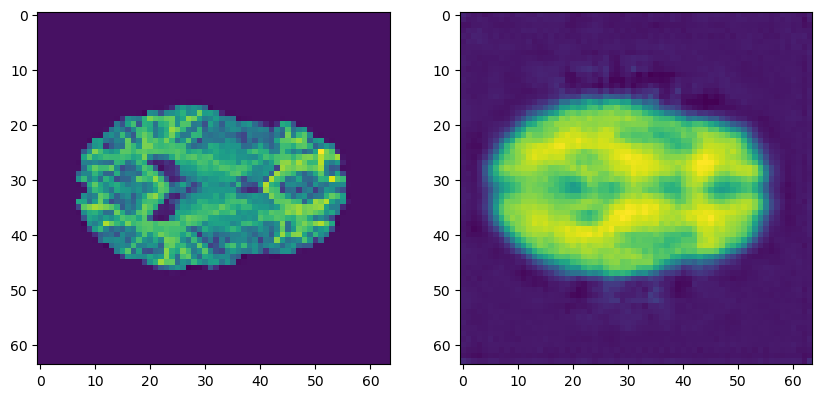

In [15]:
s = 1
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

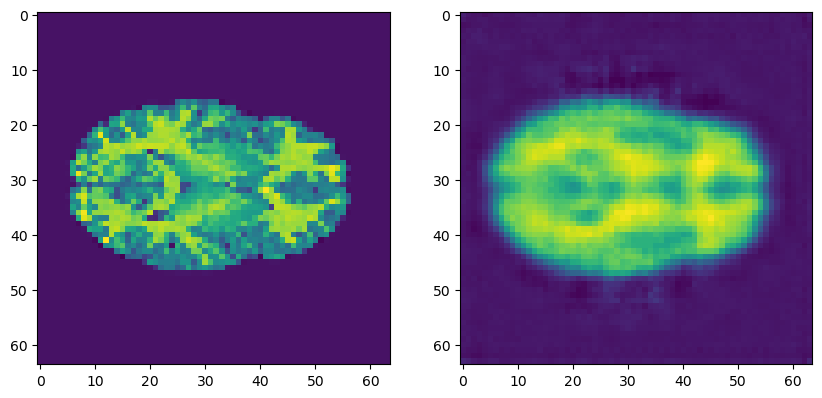

In [16]:
s = 2
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

In [15]:
# MSE subject 0
data = data_patients[0,:,:,:]
predict = recon_patients[0,:,:,:]
# Using 'auto'/'sum_over_batch_size' reduction type.
mse = tf.keras.losses.MeanSquaredError()
mse(data, predict).numpy()

0.001449396

In [20]:
# MSE subject 0
data = np.array(data_patients[0,:,:,:])
predict = np.array(recon_patients[0,:,:,:])
mse = ((data-predict)**2).mean()

0.001449396

0.001449396

In [35]:
# MSE loop
mse_list = []
for s in range(0,179):
    data = np.array(data_patients[s,:,:,:])
    predict = np.array(recon_patients[s,:,:,:])
    mse = ((data-predict)**2).mean()
    mse_list.append(mse)

mse_arr = np.array(mse_list)

#    data = data_patients[s]
#    predict = recon_patients[s]
#    # Using 'auto'/'sum_over_batch_size' reduction type.
#    mse = tf.keras.losses.MeanSquaredError()
#    mse(data, predict).numpy()

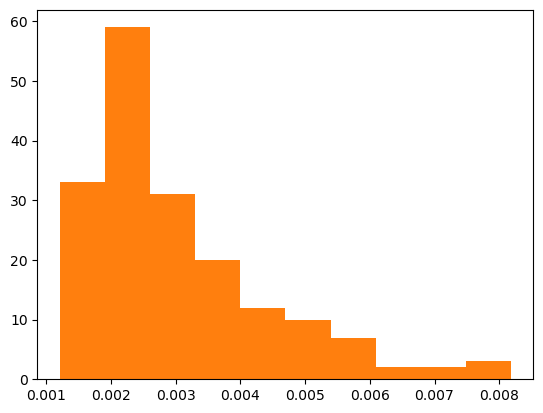

In [38]:
plt.hist(mse_arr)
plt.show()

In [36]:
mse_arr

array([0.0014494 , 0.0036268 , 0.00156431, 0.00382841, 0.00222708,
       0.00121225, 0.00207206, 0.00141514, 0.00493478, 0.00163069,
       0.00247243, 0.00386788, 0.0022689 , 0.00254134, 0.00628532,
       0.00267242, 0.00183412, 0.00187766, 0.00160509, 0.00165183,
       0.00235891, 0.00154626, 0.00224394, 0.00176225, 0.0019563 ,
       0.00258025, 0.00267471, 0.00216275, 0.00290933, 0.00274437,
       0.00158286, 0.0015663 , 0.00269017, 0.00235371, 0.00492404,
       0.00251014, 0.00309178, 0.00201624, 0.00335781, 0.00210786,
       0.00254121, 0.00274812, 0.00234466, 0.00183032, 0.00502586,
       0.00297442, 0.00188425, 0.00258594, 0.00243013, 0.00291899,
       0.00199103, 0.00362778, 0.00236673, 0.00199094, 0.00223099,
       0.00184051, 0.00236823, 0.00286549, 0.00270604, 0.00142198,
       0.00272662, 0.00197289, 0.00262362, 0.00307107, 0.00262094,
       0.00198665, 0.00123326, 0.00185079, 0.00238837, 0.00246022,
       0.00175517, 0.00227069, 0.0021309 , 0.00216886, 0.00238

In [48]:
np.argmin(mse_arr) #

5

In [51]:
np.argmax(mse_arr) #

154

In [31]:
print(mse)

0.0027558496


In [40]:
latent_shared = z_encoder.predict(data_patients)[0]
latent_specific = s_encoder.predict(data_patients)[0]

In [41]:
latent_shared.shape

(179, 2)

In [42]:
shared_similarity = make_RDM(latent_shared)
specific_similarity  = make_RDM(latent_specific)

In [43]:
data = [shared_similarity,specific_similarity]

rsa_analysis = dict()
rsa = np.array([fit_rsa(data_rdm, model_rdm)]).transpose()

NameError: name 'data_rdm' is not defined

In [45]:
data_patients.shape

(179, 64, 64, 64)

In [46]:
data_controls.shape

(261, 64, 64, 64)

In [47]:
179+261


440

In [74]:
fit_rsa??

Signature: fit_rsa(rdm_data, rdm_model)
Docstring: <no docstring>
Source:   
def fit_rsa(rdm_data,rdm_model):
    return np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
File:      /mmfs1/data/bergerar/BC-MRI-ADHD/Code/<ipython-input-73-75a28e7ba928>
Type:      function


In [ ]:
fit_rsa

ValueError: A 2-dimensional array must be passed.

In [54]:
# latent vectors
bg_features_adhd = z_encoder.predict(data_patients)[0] # returns mean,std and sample of latent vectors, we take mean here
sl_features_adhd = s_encoder.predict(data_patients)[0]

In [55]:
# latent vectors
bg_features_td = z_encoder.predict(data_controls)[0] # returns mean,std and sample of latent vectors, we take mean here
sl_features_td = s_encoder.predict(data_controls)[0]

In [80]:
reconstructions = cvae_decoder.predict(np.hstack((bg_features_adhd,sl_features_adhd)))
reconstructions = reconstructions[:,:,:,:,0]

In [85]:
reconstructions.shape

(179, 64, 64, 64)

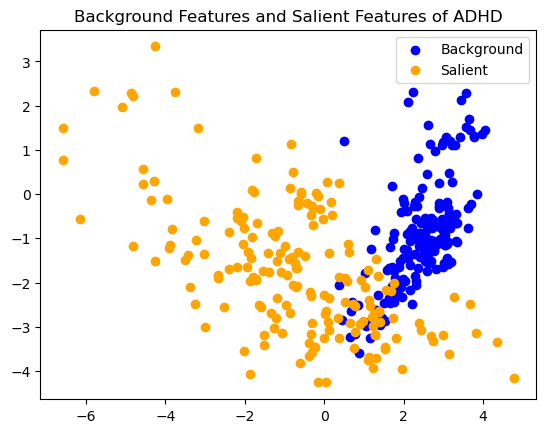

In [92]:
plt.scatter(bg_features_adhd[:,0],bg_features_adhd[:,1], label='Background', color = 'blue')
plt.scatter(sl_features_adhd[:,0],sl_features_adhd[:,1], label='Salient', color = 'orange')
plt.title('Background Features and Salient Features of ADHD')
plt.legend()
plt.show()
#what are these axes I cannot label them for the life of me but at least it looks cool
#I dont know what to title it but ... at least it looks cool

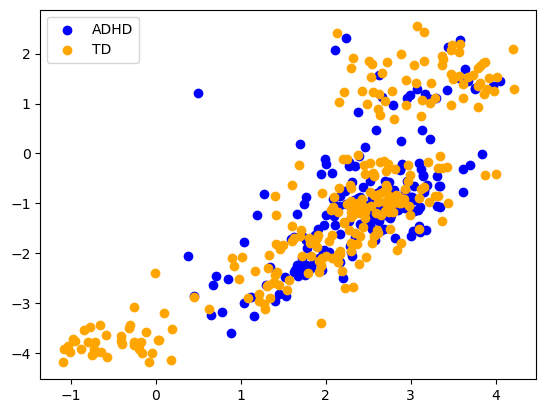

In [58]:
plt.scatter(bg_features_adhd[:,0],bg_features_adhd[:,1], label='ADHD', color = 'blue')
plt.scatter(bg_features_td[:,0],bg_features_td[:,1], label='TD', color = 'orange')
#plt.title('Background Features and Salient Features of ADHD')
plt.legend()
plt.show()
#what are these axes I cannot label them for the life of me but at least it looks cool
#I dont know what to title it but ... at least it looks cool

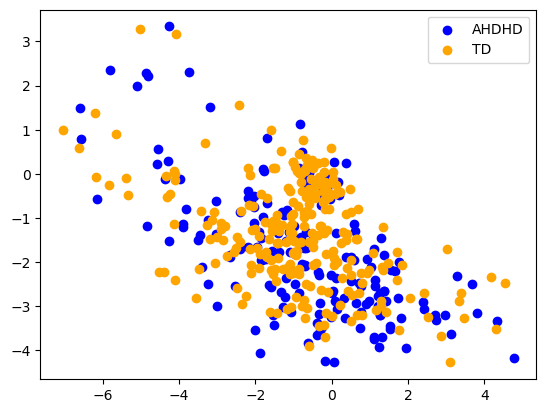

In [59]:
plt.scatter(sl_features_adhd[:,0],sl_features_adhd[:,1], label='AHDHD', color = 'blue')
plt.scatter(sl_features_td[:,0],sl_features_td[:,1], label='TD', color = 'orange')
#plt.title('Background Features and Salient Features of ADHD')
plt.legend()
plt.show()
#what are these axes I cannot label them for the life of me but at least it looks cool
#I dont know what to title it but ... at least it looks cool